# IMPORTS

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import exoplanet as xo
import astropy.units as u
from astropy.timeseries import LombScargle
import lightkurve as lk
from astropy.io import fits

from uncertainties import ufloat
from uncertainties.umath import *
from scipy import constants

import pymc as pm
import pymc_ext as pmx
import arviz as az

In [3]:
%matplotlib inline

In [4]:
mpl.rcParams["figure.figsize"] = (6, 4)
# mpl.rcParams["figure.dpi"] = 300
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.linewidth'] = 0.8
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['xtick.direction'] = 'inout'
mpl.rcParams['ytick.direction'] = 'inout'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

# Systems Parameters

In [5]:
# period, t0, K, e
stars = {
'HD224016': [796.7, 9562.8, 95, 0.6], # ref: Guillaume. P=796.7, e=0.617, K=95.0, phi0=59562.86, ST=G5V, R=1.12 Gaia DR2, logg=4.3781 Gaia DR3
'HD17820': [2098.775, 10104.3, 67, 0.45], # ref: Guillaume. P=2098.7, e=0.45, K=67.8, phi0=60104.29, ST=G0V, R=1.18 Gaia DR2, logg=4.2828 Gaia DR3
'BD+700503': [3661.8, 10836, 88, 0.38], # ref: Guillaume. P=3661.8, e=0.38, K=88.2, phi0=60835.98, ST=K2 , R=0.85 Gaia DR2, logg=4.5172, Teff=4990.9 Gaia DR3
'TOI1273': [4.6, 8712.3, 27, 0.05], # ref: Yo. P=4.6, t0=1712.3468+7000, K=26.7, e=0.05, Rstar=1.06, logg=4.37, Teff=5690
'TOI1736': [570.0, 5283, 201, 0.36], # Martioli et al 2023. https://ui.adsabs.harvard.edu/abs/2023A%26A...680A..84M/abstract, Teff=5807, logg=4.35, R=1.15
                                # two planets, non transit: Pc=570, Kc=201, T0=2455283,  e= 0.362
                                # transit: Pb=7.07, Kb=4.1, e<0.21, T0=2458792.79
        #'TOI2134': [9.2, 95.5, ] #  Rescigno et al 2023, https://ui.adsabs.harvard.edu/abs/2024MNRAS.527.5385R/abstract
                                  # two planets, transit: Pb=9.22, Kb=3.40, e=0.06, tperiastro=2459407.89
                                  # no transit: Pc=95.5, Kc=9.74, e=0.67, tperiastro=2459721.20
}
        # 'TOI1710': [24.3], # Konig et al https://aanda.org/articles/aa/pdf/2022/10/aa43002-21.pdf
                             # P=24.28, K=6.4, e=0.16, T0=2459031.23
        # 'TOI1296': [3.9], # Moutou et al https://ui.adsabs.harvard.edu/abs/2021A%26A...653A.147M/abstract P=3.94, K=34.8, e=0.05, t0=2458930.75
        # 'TOI1298': [4.5], # Moutou et al P=4.53, K=34.4, e=0.032, t0=2458929.58
        # 'HD88986': [146.0], # Heidari et al https://ui.adsabs.harvard.edu/abs/2024A%26A...681A..55H/abstract, possible second planet
                              # P=146.05, K=1.85, e=0.24, T0=58891.690 
        # 'HD207897': [16.2] # Heidari et al https://ui.adsabs.harvard.edu/abs/2022A%26A...658A.176H/abstract
                             # P=16.20, K=4.24, e=0.04, t0=2458926.1
        #}

# RV reading

In [6]:
data = {}
for i in stars:
    data["data_{0}".format(i)] = pd.read_csv('./rvs_dataset_'+i+'.csv').iloc[:, 1:] # lo último es para dropear la primera columna que estaba vacía
    print(data["data_{0}".format(i)].shape)

(26, 5)
(35, 5)
(45, 5)
(31, 5)
(30, 5)


In [7]:
list(data.keys())

['data_HD224016',
 'data_HD17820',
 'data_BD+700503',
 'data_TOI1273',
 'data_TOI1736']

In [8]:
# substract the systemic velocity 
for i in stars:
    data["data_"+i]['vrad'] = data["data_"+i]['vrad'].apply(lambda x: x - data["data_"+i]['vrad'].median())
    data["data_"+i]['vrad_corr_gb'] = data["data_"+i]['vrad_corr_gb'].apply(lambda x: x - data["data_"+i]['vrad_corr_gb'].median())
    data["data_"+i]['vrad_corr_mc'] = data["data_"+i]['vrad_corr_mc'].apply(lambda x: x - data["data_"+i]['vrad_corr_mc'].median())

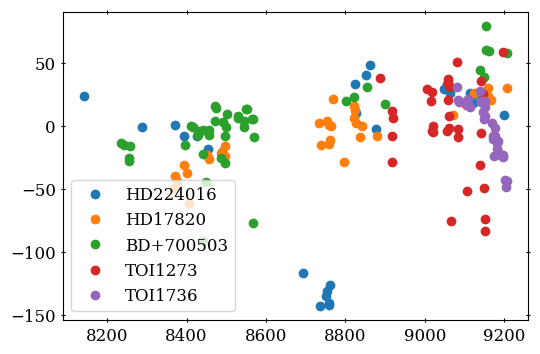

In [9]:
for i in stars:
    plt.plot(data["data_"+i]['rjd'], data["data_"+i]['vrad'], 'o', label=i)
    plt.legend(loc='best')

In [10]:
data.keys()

dict_keys(['data_HD224016', 'data_HD17820', 'data_BD+700503', 'data_TOI1273', 'data_TOI1736'])

# GLS

In [11]:
ls = dict()
ls2 = dict()
ls3 = dict()
frequency = dict()
frequency2 = dict()
frequency3 = dict()
power = dict()
power2 = dict()
power3 = dict()
faps = dict()
faps2 = dict()
faps3 = dict()

for key, value in data.items():
    ls[key] = LombScargle(value['rjd'], value['vrad'], value['svrad'])
    ls2[key] = LombScargle(value['rjd'], value['vrad_corr_gb'], value['svrad'])
    ls3[key] = LombScargle(value['rjd'], value['vrad_corr_mc'], value['svrad'])
    frequency[key], power[key] = ls[key].autopower(minimum_frequency=0.0002, maximum_frequency=2, samples_per_peak=15)
    frequency2[key], power2[key] = ls2[key].autopower(minimum_frequency=0.0002, maximum_frequency=2, samples_per_peak=15)
    frequency3[key], power3[key] = ls3[key].autopower(minimum_frequency=0.0002, maximum_frequency=2, samples_per_peak=15)
    probabilities = [0.01, 0.05]
    faps[key] = ls[key].false_alarm_level(probabilities)
    faps2[key] = ls2[key].false_alarm_level(probabilities)
    faps3[key] = ls3[key].false_alarm_level(probabilities)

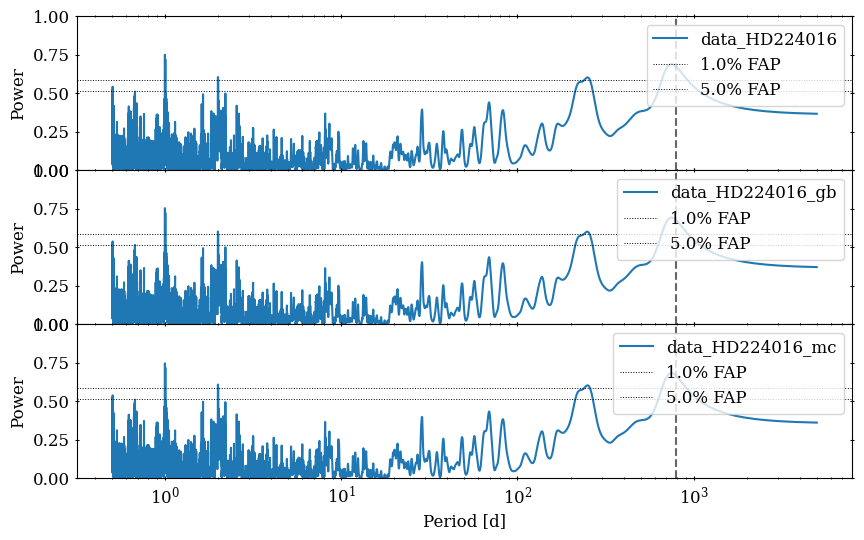

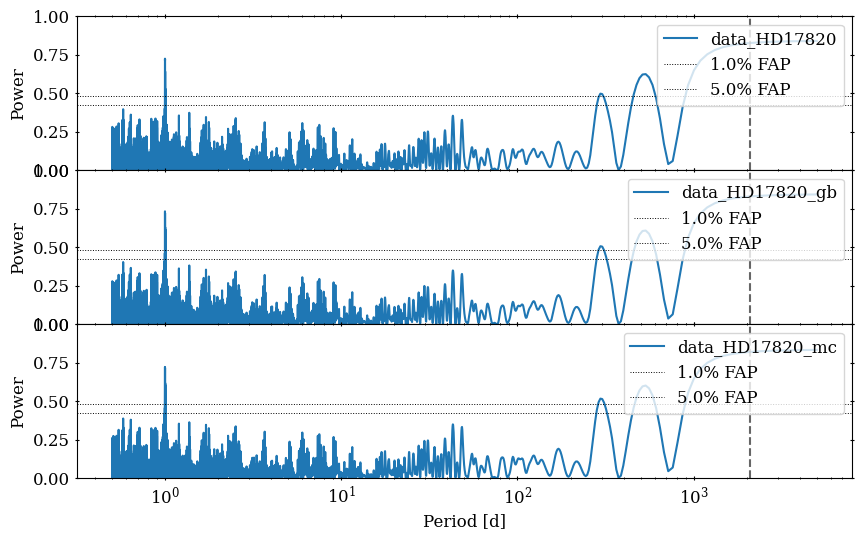

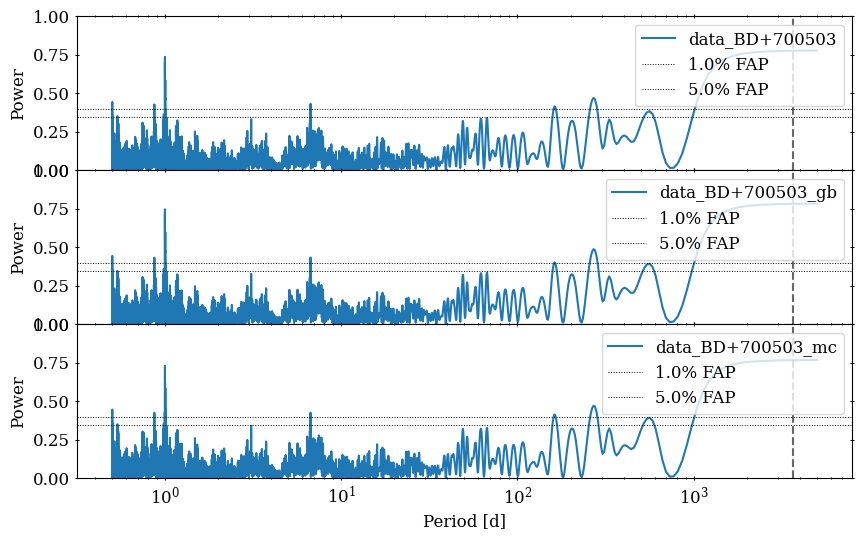

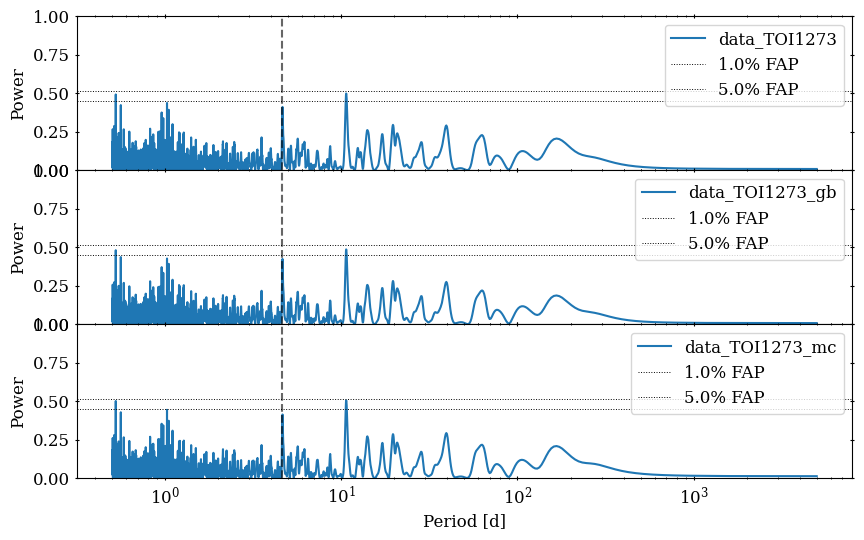

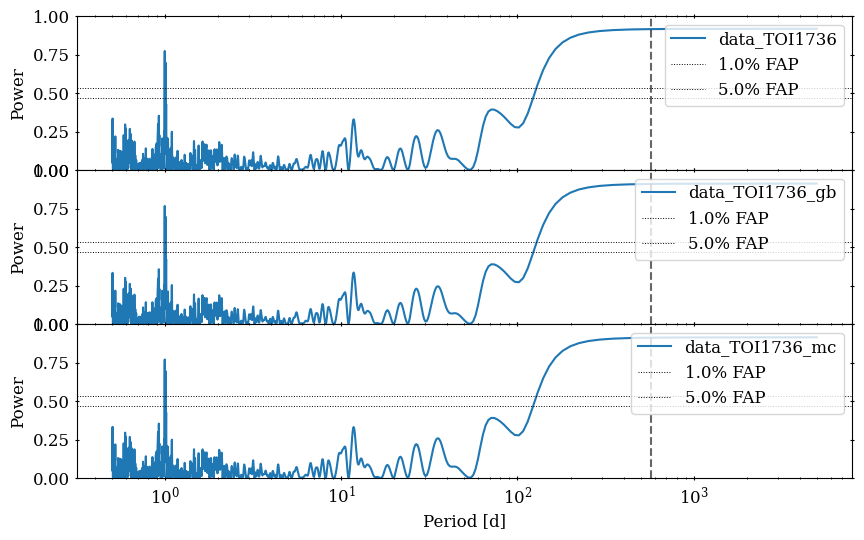

In [12]:
for i, key in enumerate(data.keys()):
    fig, axes = plt.subplots(3,1, sharex=False, figsize=(10, 6))
    fig.subplots_adjust(hspace=0.0, wspace=0.0)
    axes[0].plot(1/frequency[key], power[key], label=key)
    axes[1].plot(1/frequency2[key], power2[key], label=key+'_gb')
    axes[2].plot(1/frequency3[key], power3[key], label=key+'_mc')
    for j in range(2):
        axes[0].axhline(faps[key][j], ls=':', lw=0.7, color='black', label='{}% FAP'.format(probabilities[j]*100))
        axes[1].axhline(faps2[key][j], ls=':', lw=0.7, color='black', label='{}% FAP'.format(probabilities[j]*100))
        axes[2].axhline(faps3[key][j], ls=':', lw=0.7, color='black', label='{}% FAP'.format(probabilities[j]*100))
    for k in range(3):
        axes[k].set_xscale('log')
        #axes[k].set_xlim(0.6, 1000)
        axes[k].set_ylim(0, 1.0)
        axes[k].set_ylabel('Power')
        axes[k].set_xlabel('Period [d]')
        axes[k].legend(loc='upper right')
        axes[k].axvline(stars[key[5:]][0], ls='--', color='black', alpha=0.6, label='{} d period'.format(round(stars[key[5:]][0], 3)))

# RV fit

In [13]:
x_ref = dict()
maxrv = dict()

for key, value in data.items():
    x_ref[key] = 0.5*(value['rjd'].min() + value['rjd'].max())
    for i in range(3):
        maxrv[key+'_'+str(i)] = np.std(value['vrad'])*3

In [14]:
pmx.distributions??

Type:        module
String form: <module 'pymc_ext.distributions' from '/home/juan/anaconda3/envs/exoplanet2/lib/python3.11/site-packages/pymc_ext/distributions.py'>
File:        ~/anaconda3/envs/exoplanet2/lib/python3.11/site-packages/pymc_ext/distributions.py
Source:     
__all__ = ["angle", "unit_disk"]

import warnings

import numpy as np
import pymc as pm
import pytensor.tensor as pt


def angle(name, *, regularization=10.0, **kwargs):
    """An angle constrained to be in the range -pi to pi

    The actual sampling is performed in the two dimensional vector space
    proportional to ``(sin(theta), cos(theta))`` so that the sampler doesn't see
    a discontinuity at pi.

    The regularization parameter can be used to improve sampling performance
    when the value of the angle is well constrained. It removes prior mass near
    the origin in the sampling space, which can lead to bad geometry when the
    angle is poorly constrained, but better performance when it is. The default


In [15]:
# Make a fine grid that spans the observation window for plotting purposes
model = dict()
t = dict()

for key, value in data.items():
    t[key] = np.linspace(value['rjd'].min() - 5, value['rjd'].max() + 5, 3000)
    for i in range(3):
        with pm.Model() as model[key+'_'+str(i)]:
            P = pm.LogNormal("P", mu=np.log(stars[key[5:]][0]), sigma=0.05)
            K = pm.LogNormal("K", mu=np.log(stars[key[5:]][2]), sigma=0.1) # upper=maxrv[k]

            logs = pm.Normal("logs", mu=np.log(np.median(value['svrad'])), sigma=1.0)
            trend = pm.Normal("trend", mu=0, sigma=10.0**-np.arange(3)[::-1], shape=3)  # [2,1,0]

            # ecs0, ecs1 = pmx.unit_disk("ecs0", "ecs1")
            # ecc = pm.Deterministic("ecc", ecs0**2+ecs1**2) # tt.sum(ecs**2)
            # omega = pm.Deterministic("omega", pm.math.arctan(ecs1/ecs0))

            ecc = pm.Uniform("ecc", lower=0, upper=0.99)
            omega = pmx.angle("omega")

            t_periastron = pm.Uniform("t0", lower=value['rjd'].min(), upper=value['rjd'].max())

            orbit = xo.orbits.KeplerianOrbit(period=P, 
                                            t_periastron=t_periastron,
                                            ecc=ecc,
                                            omega=omega)

            # And a function for computing the full RV model
            def get_rv_model(t, name=""):
                # First the RVs induced by the planet
                vrad = orbit.get_radial_velocity(t, K=K)
                pm.Deterministic("vrad" + name, vrad)

                # Define the background model
                A = np.vander(t - x_ref[key], 3) # Generate a Vandermonde matrix with t-x_ref as input vector
                bkg = pm.Deterministic("bkg" + name, pm.math.dot(A, trend))

                # Sum planet and background to get the full model
                return pm.Deterministic("rv_model" + name, vrad + bkg)

            # Define the RVs at the observed times
            rv_model = get_rv_model(value['rjd'])
            # Also define the model on a fine grid as computed above (for plotting)
            rv_model_pred = get_rv_model(t[key], name="_pred")

            # Finally add in the observation model. 
            err = pm.math.sqrt(np.asarray(value['svrad'])**2  + pm.math.exp(2 * logs))
            if i==0:
                pm.Normal("obs", mu=rv_model, sigma=err, observed=value['vrad'])
            elif i==1:
                pm.Normal("obs", mu=rv_model, sigma=err, observed=value['vrad_corr_gb'])
            elif i==2:
                pm.Normal("obs", mu=rv_model, sigma=err, observed=value['vrad_corr_mc'])

In [17]:
# map_soln = dict()

# for key in data.keys():
#     for i in range(3):
#         with model[key+'_'+str(i)]:
#             map_soln[key+'_'+str(i)] = pm.find_MAP()
#             #map_soln = pmx.optimize(start=map_soln, vars=[logP, K, logs, t0])
#             map_soln[key+'_'+str(i)] = pm.find_MAP(start=map_soln)

# Sampling

In [18]:
traces = dict()

for key in data.keys():
    for i in range(3):
        with model[key+'_'+str(i)]:
            traces[key+'_'+str(i)] = pm.sample(
                tune=1000,
                draws=1000,
                #start=map_soln[key+'_'+str(i)],
                cores=None,
                chains=1,
                target_accept=0.95,
                #return_inferencedata=True,
                #init="adapt_full" # adapt_full 
            )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [P, K, logs, trend, ecc, __omega_angle1, __omega_angle2, t0]


Output()

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 20 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [P, K, logs, trend, ecc, __omega_angle1, __omega_angle2, t0]


Output()

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 28 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [P, K, logs, trend, ecc, __omega_angle1, __omega_angle2, t0]


Output()

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 21 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [P, K, logs, trend, ecc, __omega_angle1, __omega_angle2, t0]


Output()

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 26 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [P, K, logs, trend, ecc, __omega_angle1, __omega_angle2, t0]


Output()

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 24 seconds.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [P, K, logs, trend, ecc, __omega_angle1, __omega_angle2, t0]


Output()

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 36 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [P, K, logs, trend, ecc, __omega_angle1, __omega_angle2, t0]


Output()

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 40 seconds.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [P, K, logs, trend, ecc, __omega_angle1, __omega_angle2, t0]


Output()

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 49 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [P, K, logs, trend, ecc, __omega_angle1, __omega_angle2, t0]


Output()

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 47 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [P, K, logs, trend, ecc, __omega_angle1, __omega_angle2, t0]


Output()

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 254 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [P, K, logs, trend, ecc, __omega_angle1, __omega_angle2, t0]


Output()

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 72 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [P, K, logs, trend, ecc, __omega_angle1, __omega_angle2, t0]


Output()

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 65 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [P, K, logs, trend, ecc, __omega_angle1, __omega_angle2, t0]


Output()

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 24 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [P, K, logs, trend, ecc, __omega_angle1, __omega_angle2, t0]


Output()

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 74 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [P, K, logs, trend, ecc, __omega_angle1, __omega_angle2, t0]


Output()

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 20 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [23]:
summary = dict()

for key in data.keys():
    for i in range(3):
        summary[key+'_'+str(i)] = az.summary(traces[key+'_'+str(i)], stat_funcs={'median': np.median, 'std':np.std}, hdi_prob=0.997, round_to=6,
                    var_names=[
                        't0', 'P', 'ecc', 'omega', 'K', 'logs', 'trend'
                        ])
        print(summary[key+'_'+str(i)].ess_bulk.mean(), summary[key+'_'+str(i)].ess_tail.mean(), summary[key+'_'+str(i)].r_hat.max())
        st = key+'_'+str(i)
        az.to_netcdf(traces[key+'_'+str(i)], f'trace.{st}.save')

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


627.1757742222222 626.0244331111112 nan


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


748.2230761111111 664.6098321111111 nan


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


580.8375786666667 554.5452869999999 nan


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


494.2412421111111 479.4643917777778 nan


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


682.643109 632.5167352222223 nan


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


235.9966 252.34042944444445 nan


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


99.23342166666666 193.86146711111112 nan


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


400.4931166666667 358.9259935555556 nan


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


321.9065235555556 256.9521604444444 nan


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


161.1432731111111 236.976045 nan


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


397.88400711111115 371.915362 nan


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


345.6663876666667 365.6302714444444 nan


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


728.6290628888888 583.9878107777779 nan


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


761.6733298888889 611.4022 nan


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


587.7121207777778 530.6369657777777 nan


In [47]:
K = dict()
period = dict()
t_0 = dict()
eccen = dict()
rv_jitter_ = dict()
bkg_ = dict()
rv_model = dict()
rv_model_pred = dict()
rv_model_pred_ = dict()
flat_samps = dict()

boxdict = dict()
for key in data.keys():
    Ks = []
    boxdict[key] = []
    for i in range(3):
        index = key+'_'+str(i)
        boxdict[key].append(traces[index].posterior["K"].values)
        K[index] = ufloat(traces[index].posterior["K"].median().item(), traces[index].posterior["K"].std().item())
        period[index] = ufloat(traces[index].posterior['P'].median().item(),traces[index].posterior['P'].std().item())
        t_0[index] = ufloat(traces[index].posterior['t0'].median().item(), traces[index].posterior['t0'].std().item())
        eccen[index] = ufloat(traces[index].posterior["ecc"].median().item(), traces[index].posterior["ecc"].std().item())
        logsigma_rv = ufloat(traces[index].posterior["logs"].median().item(), traces[index].posterior["logs"].std().item())
        rv_jitter_[index] = np.e**logsigma_rv
        flat_samps[index] = traces[index].posterior.stack(sample=("chain", "draw"))
        bkg_[index] = np.median(flat_samps[index]['bkg'].values, axis=-1)
        rv_model[index] = np.median(flat_samps[index]['rv_model'].values, axis=-1)

        rv_model_pred[index] = np.median(flat_samps[index]['rv_model_pred'].values, axis=-1)
        rv_model_pred_[index] = np.percentile(traces[index].posterior["rv_model_pred"].values,[16, 50, 84], axis=(0, 1))

        Ks.append(K[index])

    print('Sistema', key[5:])
    print('K:', Ks[0], '    K_gb:', Ks[1], '    K_mc:', Ks[2])
    print('---------------------------------------------')

Sistema HD224016
K: 99+/-4     K_gb: 100+/-5     K_mc: 99+/-5
---------------------------------------------
Sistema HD17820
K: 66+/-7     K_gb: 66+/-6     K_mc: 64+/-6
---------------------------------------------
Sistema BD+700503
K: 86+/-9     K_gb: 85+/-9     K_mc: 86+/-8
---------------------------------------------
Sistema TOI1273
K: 27.1+/-2.8     K_gb: 27.1+/-2.8     K_mc: 27.3+/-2.6
---------------------------------------------
Sistema TOI1736
K: 197+/-20     K_gb: 114+/-8     K_mc: 199+/-19
---------------------------------------------


In [74]:
boxdict['data_HD224016'][0]

array([[104.29938519, 102.91234911,  96.50005619,  97.58744262,
         94.86921211,  97.97287331,  98.40332723, 101.48418398,
         99.44905804,  96.33064111,  99.84690255, 102.94004623,
         99.76051639, 101.53109326, 103.26311982, 103.60539718,
         95.69367703,  96.73792641,  96.57121137, 101.12457915,
         97.90823777, 100.79462304,  97.76986488,  93.32119129,
         94.19300648, 103.29009731, 107.70799217,  98.78243511,
         94.05366142,  95.489456  ,  98.7397806 ,  97.53296855,
         98.6254984 ,  98.24944835,  95.73476417,  94.71840773,
        101.15970638, 100.42170205,  98.05196478,  96.41587406,
         94.00240995,  99.43398561,  97.8840366 ,  96.32266442,
        104.23321071,  92.47989965,  95.71396067, 104.20717081,
        105.85892176, 103.05207175, 102.8905585 , 103.21874929,
         87.73292829,  88.66604797,  92.19362922, 102.28912575,
         94.93238897,  99.66393017, 100.10946721,  98.26341395,
         98.77610346,  86.9920655 ,  85.

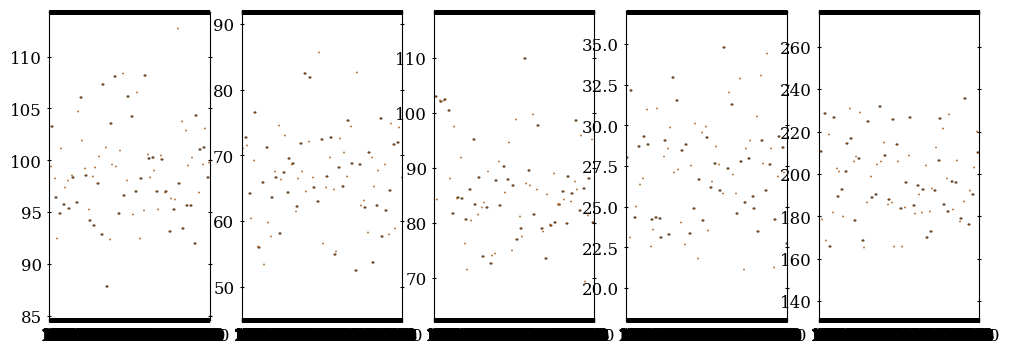

In [73]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(12, 4))

# rectangular box plot
for i, key in enumerate(data.keys()):
    bplot1 = axes[i].boxplot(boxdict[key][0],
                     vert=True,  # vertical box alignment
                     patch_artist=True)#,  # fill with color
                     #labels=list(data.keys()))  # will be used to label x-ticks